In [1]:
import os
import cv2
import torch
import shutil
import numpy as np

In [2]:
os.chdir('F:\egyptian car plates dataset\EALPR Vechicles dataset\plates models\detection_model\model3\yolov5/')

In [3]:
detection_model = torch.hub.load('.', 'custom', path='F:\egyptian car plates dataset\EALPR Vechicles dataset\plates models\detection_model\model3/best.pt', source='local')

recognition_model = torch.hub.load('.', 'custom', path=r'F:\egyptian car plates dataset\EALPR Vechicles dataset\plates models\model9/best.pt', source='local')

YOLOv5  2023-9-24 Python-3.11.5 torch-2.0.1+cpu CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
YOLOv5  2023-9-24 Python-3.11.5 torch-2.0.1+cpu CPU

Fusing layers... 
Model summary: 157 layers, 7080247 parameters, 0 gradients, 16.0 GFLOPs
Adding AutoShape... 


In [4]:
images = r'F:\egyptian car plates dataset\EALPR Vechicles dataset\plates models\detection_model\model3\images/'
cropped_img_dir = r'F:\egyptian car plates dataset\EALPR Vechicles dataset\plates models\detection_model\model3\yolov5\runs\detect'
exp_path = r'F:\egyptian car plates dataset\EALPR Vechicles dataset\plates models\detection_model\model3\yolov5\runs\detect\exp'
saved_img_dir = r'F:\egyptian car plates dataset\EALPR Vechicles dataset\plates models\detection_model\model3\saved_images'
selected_img_dir = r'F:\egyptian car plates dataset\EALPR Vechicles dataset\plates models\detection_model\model3\saved_images2\img.jpg'
selected_images_dir = r'F:\egyptian car plates dataset\EALPR Vechicles dataset\plates models\detection_model\model3\saved_images2'
resized_img_dir = r'F:\egyptian car plates dataset\EALPR Vechicles dataset\plates models\detection_model\model3\resized_images'

In [51]:
def delete_folder_or_file(path):
    try:
        if os.path.exists(path):
            folder_path = path.split("\\")
            if "exp" in folder_path:
                shutil.rmtree(path)
            else:
                for img in os.listdir(path):
                    img_path = os.path.join(path, img)
                    # Use os.remove() to delete the file
                    os.remove(img_path)
            return "Deletion completed successfully"
        else:
            return "Path does not exist"
    except FileNotFoundError as e:
        return f"Error occurred while deleting the file/folder: {e}"

In [52]:
def if_folder_exists():
    folder_path = r"F:\egyptian car plates dataset\EALPR Vechicles dataset\plates models\detection_model\model3\yolov5\runs\detect\exp\crops"
    if os.path.exists(folder_path):
        return("1")

In [7]:
def save_cropped_img(cropped_img_dir, saved_img_dir):
    for filename in os.listdir(cropped_img_dir):
        for crops in os.listdir(os.path.join(cropped_img_dir, filename)):
            if crops == "crops":
                for plate in os.listdir(os.path.join(cropped_img_dir, filename, crops)):
                    for img in os.listdir(os.path.join(cropped_img_dir, filename, crops, plate)):
                        img_path = os.path.join(cropped_img_dir, filename, crops, plate, img)
                        image = cv2.imread(img_path)
                        cv2.imwrite(saved_img_dir + "//" + img, image)
    return

In [8]:
def select_img(saved_img_dir, selected_img_dir):
    folder_path = saved_img_dir

    # Check if there are any images in the directory
    if not any(os.path.isfile(os.path.join(folder_path, filename)) for filename in os.listdir(folder_path)):
        print(f"No images found in {folder_path}. Exiting.")
        return

    image_data = {}
    for filename in os.listdir(folder_path):
        if os.path.isfile(os.path.join(folder_path, filename)):
            image_path = os.path.join(folder_path, filename)
            img = cv2.imread(image_path)
            if img is not None:
                height, width, _ = img.shape
                image_data[filename] = height * width

    desired_value = max(image_data.values())
    keys = [key for key, value in image_data.items() if value == desired_value]

    x = folder_path + "\\" + keys[0]
    image = cv2.imread(x)
    
    if image is not None:
        cv2.imwrite(selected_img_dir, image)
    else:
        print(f"Error: Failed to read or process the selected image.")
        return

In [9]:
def resize_img(selected_images_dir, resized_img_dir):
    # Create the output folder if it doesn't exist
    os.makedirs(resized_img_dir, exist_ok=True)
    # Iterate over the files in the input folder
    for filename in os.listdir(selected_images_dir):
        input_path = os.path.join(selected_images_dir, filename)
        output_path = os.path.join(resized_img_dir, filename)

        # Check if the file is an image
        if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png'):
            # Read the image
            image = cv2.imread(input_path)

            # Check if the image was successfully read
            if image is not None:
                ratio = 600 / image.shape[1]
                width = round(image.shape[1] * ratio)
                height = round(image.shape[0] * ratio)

                # Resize the image
                resized_image = cv2.resize(image, (width, height))

                # Save the resized image to the output folder
                cv2.imwrite(output_path, resized_image)
                # print(f"Resized image saved: {output_path}")
            else:
                print(f"Failed to read image: {input_path}")
        else:
            print(f"Skipping non-image file: {input_path}")

In [10]:
def reverse_labels_and_boxes(img_path):
    for img in os.listdir(img_path):
        image_path = img_path + "\\" + img
    results = recognition_model(image_path)

    # Get the predicted labels and bounding box coordinates
    labels = results.xyxyn[0][:, -1].cpu().numpy()
    boxes = results.xyxyn[0][:, :-1].cpu().numpy()

    # Get the class names associated with the model
    class_names = recognition_model.module.names if hasattr(recognition_model, 'module') else recognition_model.names

    # Reverse the order of labels and bounding boxes
    reversed_labels = labels[::-1]
    reversed_boxes = boxes[::-1]
    return reversed_labels, reversed_boxes, class_names

In [11]:
def return_model_result(reversed_labels, reversed_boxes, class_names):        
        # Initialize an empty dictionary to store the results
        model_result = {}

        # Iterate over the reversed bounding box coordinates and labels
        for label, box in zip(reversed_labels, reversed_boxes):
            # Get the label name using the model's class names
            label_name = class_names[int(label)]

            # Check if the label name already exists in the dictionary
            if label_name in model_result:
                # If the label name exists, append the bounding box to the existing list
                model_result[label_name].append(box[0])
            else:
                # If the label name doesn't exist, create a new list with the bounding box
                model_result[label_name] = [box[0]]

        # Print the model_result dictionary
        return model_result

In [12]:
def return_sorted_plate_characters(reversed_labels, reversed_boxes,class_names, model_result):
    lst = []
    for label, box in zip(reversed_labels, reversed_boxes):
        # Get the label name using the model's class names
        label_name = class_names[int(label)]

        lst.append(box[0])

    lst.sort()  # Sort the list of bounding boxes in ascending order

    # Initialize an empty list to store the matching keys
    matching_keys = []

    # Iterate over the elements in lst
    for item in lst:
        found_match = False
        for key, value in model_result.items():
            if np.allclose(value, item):
                matching_keys.append(key)
                found_match = True
                break
        if not found_match:
            # Check if the item matches any array value element-wise
            for key, value in model_result.items():
                if any(np.allclose(v, item) for v in value):
                    matching_keys.append(key)
                    break

    # return the matching keys
    return matching_keys

In [13]:
replace_arabic_characters_and_digits = {"zero": 0, "one": 1, "two": 2, "three": 3, "four": 4, "five": 5, "six": 6, "seven": 7, "eight": 8, "nine": 9,
                                        "alif":"أ", "baa":"ب", "geem":"ج", "daal":"د", "raa":"ر", "seen":"س", "saad":"ص", "taa":"ط",
                                        "ein":"ع", "faa":"ف", "qaaf":"ق","kaaf":"ك", "laam":"ل", "meem":"م", "noon":"ن", "haa":"ه", "waaw":"و", "yaa":"ي"}

In [14]:
def convert_plate_characters(matching_keys):
    # Initialize an empty list to store the corresponding values
    matching_values = []

    # Iterate over the keys in matching_keys
    for key in matching_keys:
        if key in replace_arabic_characters_and_digits:
            value = replace_arabic_characters_and_digits[key]
            matching_values.append(value)

    # Print the matching values
    return matching_values

In [15]:
def join_digits_and_sort_characters(matching_values):
    numbers = ""
    characters = ""
    for item in matching_values:
        item_str = str(item)  # Convert item to string
        if item_str.isdigit():
            numbers += item_str
        else:
            characters += item_str
    separated_characters = list(characters[::-1])
    result_list = [numbers, separated_characters]
    return result_list

In [16]:
def get_governorate(result_list):
    replace_first_element = {"س": "الإسكندرية", "ر": "الشرقية", "د": "الدقهلية", "م": "المنوفية", "ب": "البحيرة",
                             "ل": "كفر الشيخ", "ع": "الغربية", "ق": "القليوبية", "ف": "الفيوم", "و": "بني سويف",
                             "ن": "المنيا", "ي": "أسيوط", "ه": "سوهاج", "أ": "القاهرة"}

    replace_second_element_if_first_geem = {"ه": "مطروح", "ب": "الوادي الجديد"}

    replace_second_element_if_first_saad = {"أ": "قنا", "ق": "الأقصر", "و": "أسوان"}

    replace_second_element_if_first_taa = {"س": "السويس", "ن": "الاسماعيلية","ص": "الاسماعيلية", "ب": "بورسعيد","ع": "بورسعيد", "د": "دمياط",
                                           "أ": "شمال سيناء", "ج": "جنوب سيناء", "ر": "البحر الأحمر"}
    
    if len(result_list[0]) >= 5 and len(result_list[1]) == 0:
            value = "دبلوماسية"               
    if len(result_list[0]) == 6 and len(result_list[1]) == 1:
            value = "شرطة"
    elif len(result_list[1]) >= 2:
        first_char = result_list[1][0]
        sec_char = result_list[1][1]
        if len(result_list[0]) == 3 and len(result_list[1]) == 3:
            value = "القاهرة"
        elif len(result_list[0]) == 4 and len(result_list[1]) == 2:
            value = "الجيزة"
        elif len(result_list[0]) == 4 and len(result_list[1]) == 3:
            if first_char == "ج":
                value = replace_second_element_if_first_geem.get(sec_char, "أخرى")
            elif first_char == "ص":
                value = replace_second_element_if_first_saad.get(sec_char, "أخرى")
            elif first_char == "ط":
                value = replace_second_element_if_first_taa.get(sec_char, "أخرى")
            else:
                value = replace_first_element.get(first_char, "أخرى")
        else:
            value = "أخرى"
    else:
        value = "أخرى"
    
    return value

In [17]:
def append_governorate_to_result_list(result_list, value):
    value = get_governorate(result_list)
    result_list.append(value)
    return result_list

In [18]:
def if_police_car(final_result):
    lst = []
    prefix = final_result[0][-2:]  # Get the last two digits of the first element
    for i in final_result[0][:-2]:
        lst.append(i)
    final_result = ["".join(lst), [prefix + final_result[1][0]], "شرطة"]
    return final_result

In [19]:
def check_if_police_car(final_result):
    if len(final_result[0]) == 6 and len(final_result[1]) == 1:
        final_result = if_police_car(final_result)
        return final_result
    else:
        return final_result

In [20]:
digits_mapping = {
        '1': '١',
        '2': '٢',
        '3': '٣',
        '4': '٤',
        '5': '٥',
        '6': '٦',
        '7': '٧',
        '8': '٨',
        '9': '٩'
        }

In [21]:
def convert_digits(text):        
    converted_text = ""
    for char in text:
        if char.isdigit():
            converted_text += digits_mapping[char]
        else:
            converted_text += char
    return converted_text

In [22]:
def convert_to_arabic_digits(final_result):
    original_list = final_result
    converted_list = []
    for item in original_list:
        if isinstance(item, str):
            converted_list.append(convert_digits(item))
        else:
            converted_list.append([convert_digits(subitem) for subitem in item])
    return converted_list

In [23]:
def swap_elements(final_result):
    final_result[0], final_result[1] = final_result[1], final_result[0]
    return final_result

In [25]:
# def check_if_police(final_result, final):
#     if len(final[0]) == 6:
#         final_result[0] = [if_police_move_character_to_beginning(final_result, item, 'ب') for item in final_result[0]]
#         return final_result
#     else:
#         return final_result

In [24]:
def check_if_police(final_result, final):
    if len(final[0]) == 6 and len(final[1]) == 1:
        final_result[0] = [if_police_move_character_to_beginning(final_result, item, 'ب') for item in final_result[0]]
        return final_result
    else:
        return final_result

In [25]:
def if_police_move_character_to_beginning(final_result, text, char):
    # Remove the character from the original position
    text = text.replace(char, '')

    # Insert the character at the beginning
    text = char + text

    return text

In [26]:
def if_diplomatic_car(final_result):
    final_result[2] = "دبلوماسية"
    return final_result

In [27]:
def check_if_diplomatic(final_result):
    if len(final_result[0]) >= 5 and len(final_result[1]) == 0:
        final_result = if_diplomatic_car(final_result)
        return final_result
    else:
        return final_result

In [28]:
def return_final_result(exp_path, detection_model, images, cropped_img_dir, selected_img_dir, selected_images_dir, resized_img_dir):
    res = if_folder_exists()
    if res == "1":
        save_cropped_img(cropped_img_dir, saved_img_dir)
        select_img(saved_img_dir, selected_img_dir)
        resize_img(selected_images_dir, resized_img_dir)
        reversed_labels, reversed_boxes, class_names = reverse_labels_and_boxes(resized_img_dir)
        model_result = return_model_result(reversed_labels, reversed_boxes, class_names)
        matching_keys = return_sorted_plate_characters(reversed_labels, reversed_boxes, class_names, model_result)
        matching_values = convert_plate_characters(matching_keys)
        result_list = join_digits_and_sort_characters(matching_values)
        governorate = get_governorate(result_list)
        result = append_governorate_to_result_list(result_list, governorate)
        final_result = check_if_police_car(result)
        final_result = convert_to_arabic_digits(final_result)
        final_result = swap_elements(final_result)
        final_result = check_if_police(final_result, result)
        return final_result
    else:
        return [[], '', 'أخرى']

In [29]:
def apply_detection_model_and_save_results(model, images_path):
    for img in os.listdir(images):
        try:
            img_path = os.path.join(images_path, img)
            result = model(img_path)
#             accuracy = result.xyxyn[0][:, -2].cpu().numpy()[0]
            crops = result.crop(save=True)
        except (OSError, cv2.error) as e:
            print(f"Error processing image {img}: {e}")
            continue

In [30]:
def return_final_result(exp_path, detection_model, images, cropped_img_dir, saved_img_dir, selected_img_dir, selected_images_dir, resized_img_dir):
    delete_folder_or_file(exp_path)    
    delete_folder_or_file(saved_img_dir)
    delete_folder_or_file(selected_images_dir)
    delete_folder_or_file(resized_img_dir)
    apply_detection_model_and_save_results(detection_model, images)
    res = if_folder_exists()
    if res == "1":
        save_cropped_img(cropped_img_dir, saved_img_dir)
        select_img(saved_img_dir, selected_img_dir)
        resize_img(selected_images_dir, resized_img_dir)
        reversed_labels, reversed_boxes, class_names = reverse_labels_and_boxes(resized_img_dir)
        model_result = return_model_result(reversed_labels, reversed_boxes, class_names)
        matching_keys = return_sorted_plate_characters(reversed_labels, reversed_boxes, class_names, model_result)
        matching_values = convert_plate_characters(matching_keys)
        result_list = join_digits_and_sort_characters(matching_values)
        governorate = get_governorate(result_list)
        result = append_governorate_to_result_list(result_list, governorate)
        final_result = check_if_police_car(result)
        final_result = check_if_diplomatic(result)
        final_result = convert_to_arabic_digits(final_result)
        final_result = swap_elements(final_result)
        final_result = check_if_police(final_result, result)
        return final_result
    else:
        return [[], '', 'أخرى']

In [37]:
final_result = return_final_result(exp_path, detection_model, images, cropped_img_dir, saved_img_dir, selected_img_dir, selected_images_dir, resized_img_dir)

Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



In [31]:
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg

In [35]:
def show_image_and_final_result(img):
    print(final_result)
    img = mpimg.imread(img)
    imgplot = plt.imshow(img)
    plt.show()
    return

In [39]:
def show_image_and_final_result(images):
    print(final_result)
    for img in os.listdir(images):
                img_path = images + "\\" + img
    img = mpimg.imread(img_path)
    imgplot = plt.imshow(img)
    plt.show()
    return

In [57]:
# def show_image_and_final_result(images):
#     # Check if the directory is empty
#     if not os.listdir(images):
#         print(f"No images found.")
#         return  # or raise an exception, return a default value, or handle the case as needed

#     # Iterate over the images in the directory
#     for img in os.listdir(images):
#         img_path = os.path.join(images, img)
#         img = mpimg.imread(img_path)
#         imgplot = plt.imshow(img)
#         plt.show()

In [33]:
%matplotlib inline

In [35]:
# def perform_object_detection(frame):
#     results = detection_model(frame)
#     crops = results.crop(save=True)
#     return results

[[], '١٩٤١٦', 'دبلوماسية']


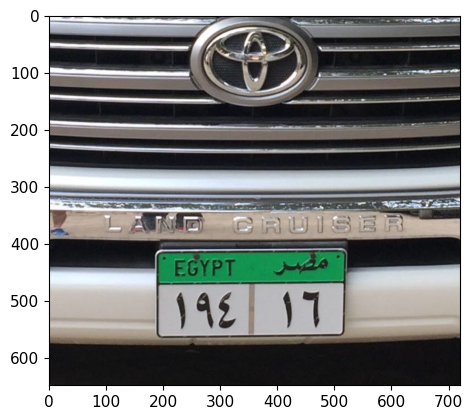

In [40]:
show_image_and_final_result(images)

[['ه', 'و', 'ف'], '٩٥٧', 'القاهرة']


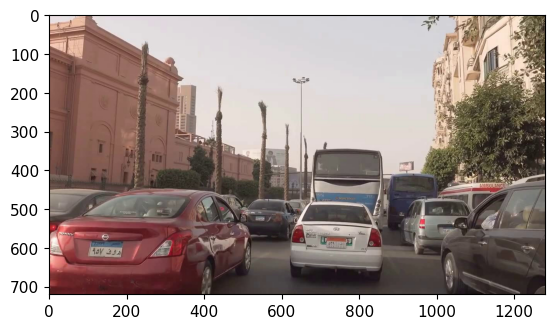

In [79]:
show_image_and_final_result(images)

[['ن', 'و', 'ق'], '٦١٧', 'القاهرة']


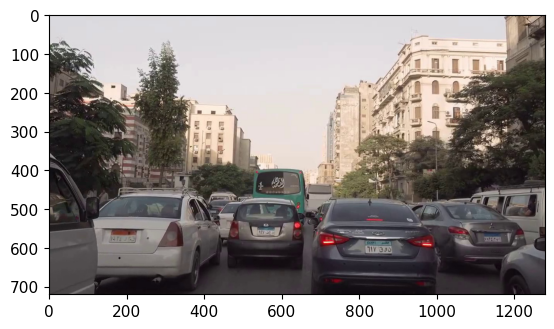

In [81]:
show_image_and_final_result(images)

[['د', 'ب', 'ف'], '٩٨٧', 'القاهرة']


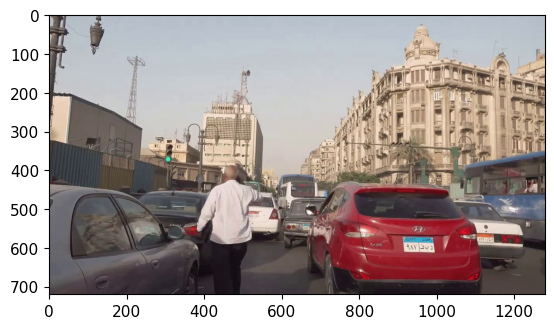

In [83]:
show_image_and_final_result(images)

[['و', 'ع', 'ق'], '٧٩٤٦', 'بني سويف']


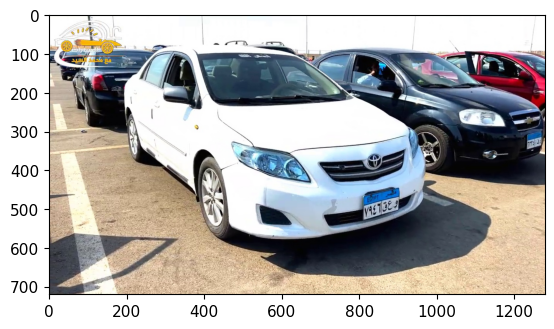

In [85]:
show_image_and_final_result(images)

[[], '', 'أخرى']


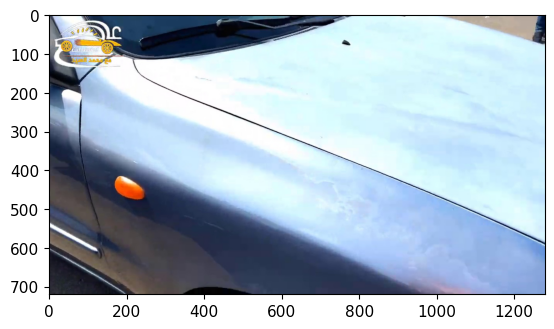

In [88]:
show_image_and_final_result(images)

In [41]:
# image = r"F:\egyptian car plates dataset\EALPR Vechicles dataset\plates models\detection_model\model3\yolov5\runs\detect\exp\image0.jpg"
# show_image_and_final_result(image)

[[], '١٩٤١٦', 'دبلوماسية']


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'F:\\egyptian car plates dataset\\EALPR Vechicles dataset\\plates models\\detection_model\\model3\\yolov5\\runs\\detect\\exp\\image0.jpg'

In [43]:
def return_final_result(exp_path, detection_model, images, cropped_img_dir, saved_img_dir, selected_img_dir, selected_images_dir, resized_img_dir):
    delete_folder_or_file(exp_path)    
    delete_folder_or_file(saved_img_dir)
    delete_folder_or_file(selected_images_dir)
    delete_folder_or_file(resized_img_dir)
    apply_detection_model_and_save_results(detection_model, images)
    res = if_folder_exists()
    if res == "1":
        save_cropped_img(cropped_img_dir, saved_img_dir)
        select_img(saved_img_dir, selected_img_dir)
        resize_img(selected_images_dir, resized_img_dir)
        reversed_labels, reversed_boxes, class_names = reverse_labels_and_boxes(resized_img_dir)
        model_result = return_model_result(reversed_labels, reversed_boxes, class_names)
        matching_keys = return_sorted_plate_characters(reversed_labels, reversed_boxes, class_names, model_result)
        matching_values = convert_plate_characters(matching_keys)
        result_list = join_digits_and_sort_characters(matching_values)
        governorate = get_governorate(result_list)
        result = append_governorate_to_result_list(result_list, governorate)
        final_result = check_if_police_car(result)
        final_result = convert_to_arabic_digits(final_result)
        final_result = swap_elements(final_result)
        final_result = check_if_police(final_result, result)
        return final_result
    else:
        return [[], '', 'أخرى']

In [53]:
def perform_object_detection(frame):
    results = detection_model(frame)
    crops = results.crop(save=True)
    return results

In [54]:
def return_final_result(exp_path, detection_model, images, cropped_img_dir, saved_img_dir, selected_images_dir, resized_img_dir):
#     apply_detection_model_and_save_results(detection_model, images)
    res = if_folder_exists()
    if res == "1":
        save_cropped_img(cropped_img_dir, saved_img_dir)
        select_img(saved_img_dir, selected_img_dir)
        resize_img(saved_img_dir, resized_img_dir)
        reversed_labels, reversed_boxes, class_names = reverse_labels_and_boxes(resized_img_dir)
        model_result = return_model_result(reversed_labels, reversed_boxes, class_names)
        matching_keys = return_sorted_plate_characters(reversed_labels, reversed_boxes, class_names, model_result)
        matching_values = convert_plate_characters(matching_keys)
        result_list = join_digits_and_sort_characters(matching_values)
        governorate = get_governorate(result_list)
        result = append_governorate_to_result_list(result_list, governorate)
        final_result = check_if_police_car(result)
        final_result = convert_to_arabic_digits(final_result)
        final_result = swap_elements(final_result)
        final_result = check_if_police(final_result, result)
        return final_result
    else:
        return [[], '', 'أخرى']

WARNING  NMS time limit 0.550s exceeded
Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ه', 'س', 'ع'], '٧٦٨', 'القاهرة']


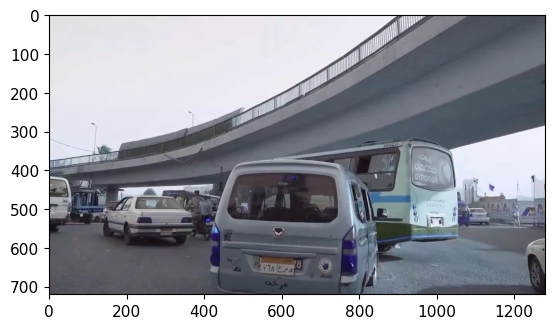

Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ه', 'ص', 'ع'], '٧٦٨', 'القاهرة']


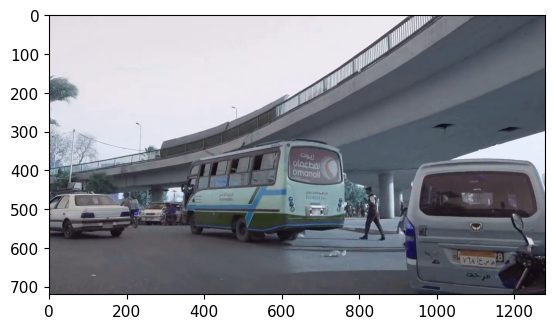

Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ل', 'ي', 'ط'], '٤٦١', 'القاهرة']


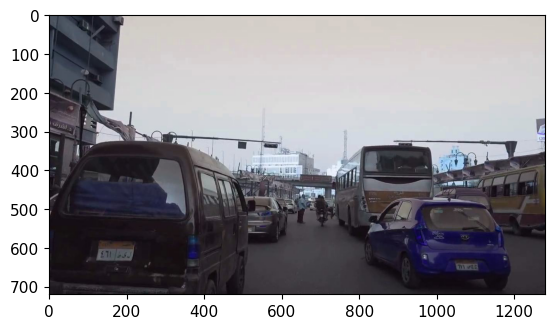

Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ن', 'و'], '٢٩١٨', 'الجيزة']


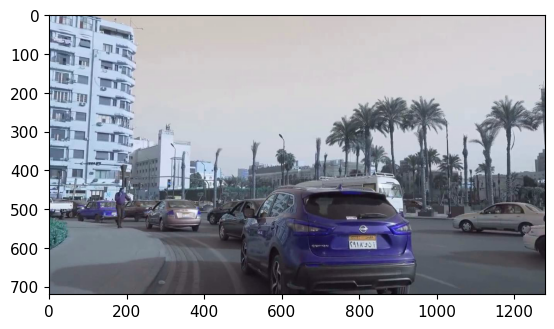

Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ر'], '١٥٦٣', 'الجيزة']


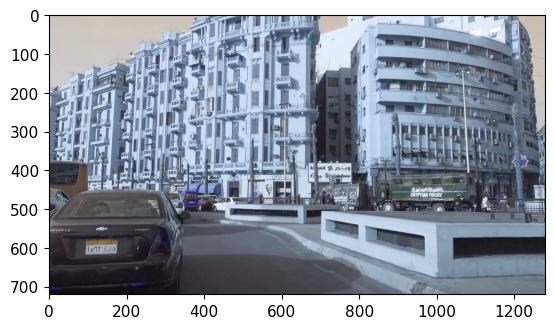

Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['أ', 'ي', 'ص'], '٧٣٥٩', 'القاهرة']


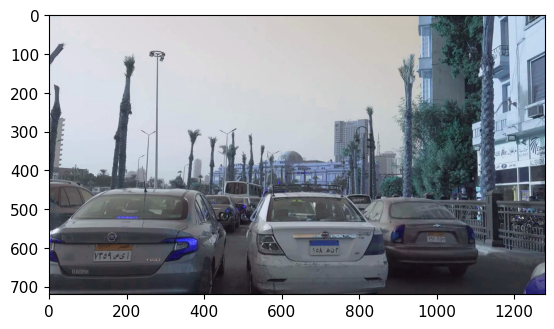

Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ه', 'و', 'ف'], '٩٥٧', 'القاهرة']


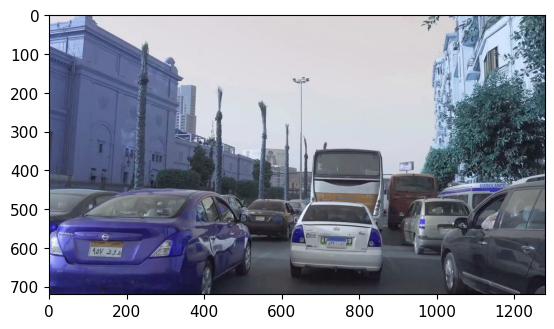

Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ب', 'ع', 'ط'], '٦٨٢', 'القاهرة']


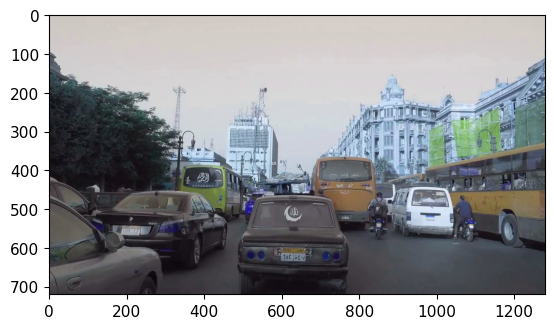

Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ب', 'ف'], '٩٨٧', 'القاهرة']


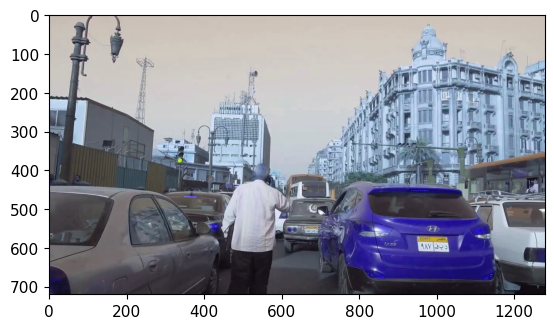

Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[[], '', 'أخرى']


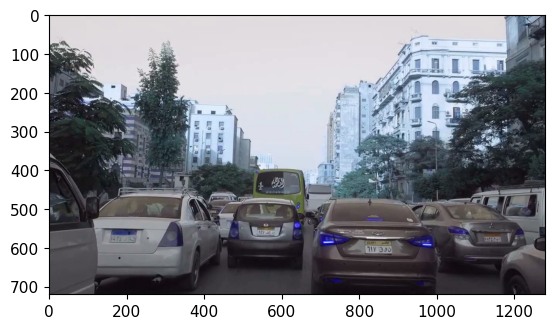

Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ق'], '٩٨٥٩', 'الجيزة']


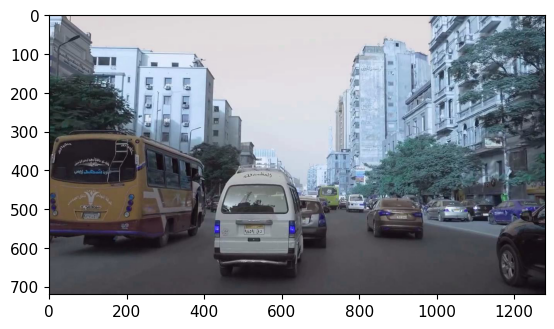

In [169]:
cars_plates_lst = []
# Define the path to the input video file
video_path = r"C:\Users\pc\Videos\Download Videos\one_video\test_video1.mp4"

# Define the output directory for saving the frames
output_dir = r"F:\egyptian car plates dataset\EALPR Vechicles dataset\plates models\detection_model\model3\saved_frames3"
os.makedirs(output_dir, exist_ok=True)

# Initialize the video capture object
cap = cv2.VideoCapture(video_path)

# Initialize variables for frame extraction
frame_count = 0
frame_rate = 10  # Extract a frame every second

# Loop through the frames of the video and extract frames at the specified frame rate
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Check if it's time to extract a frame
    if frame_count % int(cap.get(cv2.CAP_PROP_FPS)) == 0:
        # Save the frame as an image in the output directory
#         cv2.imwrite(os.path.join(output_dir, f"frame{frame_count}.jpg"), frame)
        delete_folder_or_file(exp_path)    
        delete_folder_or_file(saved_img_dir)
        delete_folder_or_file(selected_images_dir)
        delete_folder_or_file(resized_img_dir)
        results = perform_object_detection(frame)
#         print(results)
        # accuracy = results.xyxyn[0][:, -2].cpu().numpy()[0]
        # if accuracy > 0.5:
#         crops = results.crop(save=True)
        final_result = return_final_result(exp_path, detection_model, images, cropped_img_dir, saved_img_dir, selected_img_dir, resized_img_dir)
        if final_result != "2":
            image = r"F:\egyptian car plates dataset\EALPR Vechicles dataset\plates models\detection_model\model3\yolov5\runs\detect\exp\image0.jpg"
            show_image_and_final_result(image)
            if final_result not in cars_plates_lst:
                cars_plates_lst.append(final_result)
        else:
            continue
        
    # Increment the frame count
    frame_count += 2

    # Set the video capture object to the next frame at the specified frame rate
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_count * frame_rate)

# Release the video capture object
cap.release()

for element in cars_plates_lst:
    if element == [[], '', 'أخرى']:
        cars_plates_lst.remove(element)
    else:
        continue

In [170]:
cars_plates_lst 

[[['ه', 'س', 'ع'], '٧٦٨', 'القاهرة'],
 [['ه', 'ص', 'ع'], '٧٦٨', 'القاهرة'],
 [['ل', 'ي', 'ط'], '٤٦١', 'القاهرة'],
 [['ن', 'و'], '٢٩١٨', 'الجيزة'],
 [['د', 'ر'], '١٥٦٣', 'الجيزة'],
 [['أ', 'ي', 'ص'], '٧٣٥٩', 'القاهرة'],
 [['ه', 'و', 'ف'], '٩٥٧', 'القاهرة'],
 [['ب', 'ع', 'ط'], '٦٨٢', 'القاهرة'],
 [['د', 'ب', 'ف'], '٩٨٧', 'القاهرة'],
 [['د', 'ق'], '٩٨٥٩', 'الجيزة']]

In [92]:
import time

In [107]:
cars_plates_lst = []
# Define the path to the input video file
video_path = r"C:\Users\pc\Videos\Download Videos\one_video\test_video1.mp4"

# # Define the output directory for saving the frames
# output_dir = r"F:\egyptian car plates dataset\EALPR Vechicles dataset\plates models\detection_model\model3\saved_frames3"
# os.makedirs(output_dir, exist_ok=True)

# Initialize the video capture object
cap = cv2.VideoCapture(video_path)

# Initialize variables for frame extraction
frame_count = 0
frame_rate = 1  # Extract a frame every second

# Loop through the frames of the video and extract frames at the specified frame rate
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Check if it's time to extract a frame
    if frame_count % int(cap.get(cv2.CAP_PROP_FPS)) == 0:
#         start_time = time.time()
        # Save the frame as an image in the output directory
#         cv2.imwrite(os.path.join(output_dir, f"frame{frame_count}.jpg"), frame)
        delete_folder_or_file(exp_path)    
        delete_folder_or_file(saved_img_dir)
        delete_folder_or_file(selected_images_dir)
        delete_folder_or_file(resized_img_dir)
        results = perform_object_detection(frame)
#         print(results)
        # accuracy = results.xyxyn[0][:, -2].cpu().numpy()[0]
        # if accuracy > 0.5:
#         crops = results.crop(save=True)
        final_result = return_final_result(exp_path, detection_model, images, cropped_img_dir, saved_img_dir, selected_img_dir, resized_img_dir)
        if final_result != "2":
#             print(final_result)
            if final_result not in cars_plates_lst:
                cars_plates_lst.append(final_result)
#                 elapsed_time = time.time() - start_time
#                 print(elapsed_time)
        else:
#             elapsed_time = time.time() - start_time
#             print(elapsed_time)
            continue
        
    # Increment the frame count
    frame_count += 2

    # Set the video capture object to the next frame at the specified frame rate
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_count * frame_rate)

# Release the video capture object
cap.release()

for element in cars_plates_lst:
    if element == [[], '', 'أخرى']:
        cars_plates_lst.remove(element)
    else:
        continue

Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp

Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp

Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp

Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp

Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp

Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp

Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp

Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp

Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp

Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp

Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



In [108]:
cars_plates_lst

[[['ه', 'س', 'ع'], '٧٦٨', 'القاهرة'],
 [['ه', 'ص', 'ع'], '٧٦٨', 'القاهرة'],
 [['ل', 'ي', 'ط'], '٤٦١', 'القاهرة'],
 [['ن', 'و'], '٢٩١٨', 'الجيزة'],
 [['د', 'ر'], '١٥٦٣', 'الجيزة'],
 [['أ', 'ي', 'ص'], '٧٣٥٩', 'القاهرة'],
 [['ه', 'و', 'ف'], '٩٥٧', 'القاهرة'],
 [['ب', 'ع', 'ط'], '٦٨٢', 'القاهرة'],
 [['د', 'ب', 'ف'], '٩٨٧', 'القاهرة'],
 [['د', 'ق'], '٩٨٥٩', 'الجيزة']]

In [60]:
cars_plates_lst = []
# Define the path to the input video file
video_path = r"C:\Users\pc\Videos\Download Videos\one_video\test_video1.mp4"

# # Define the output directory for saving the frames
# output_dir = r"F:\egyptian car plates dataset\EALPR Vechicles dataset\plates models\detection_model\model3\saved_frames3"
# os.makedirs(output_dir, exist_ok=True)

# Initialize the video capture object
cap = cv2.VideoCapture(video_path)

# Initialize variables for frame extraction
frame_count = 0
frame_rate = 1  # Extract a frame every second

# Loop through the frames of the video and extract frames at the specified frame rate
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Check if it's time to extract a frame
    if frame_count % int(cap.get(cv2.CAP_PROP_FPS)) == 0:
        # Save the frame as an image in the output directory
#         cv2.imwrite(os.path.join(output_dir, f"frame{frame_count}.jpg"), frame)
        delete_folder_or_file(exp_path)    
        delete_folder_or_file(saved_img_dir)
        delete_folder_or_file(selected_images_dir)
        delete_folder_or_file(resized_img_dir)
        results = perform_object_detection(frame)
#         print(results)
        # accuracy = results.xyxyn[0][:, -2].cpu().numpy()[0]
        # if accuracy > 0.5:
#         crops = results.crop(save=True)
        final_result = return_final_result(exp_path, detection_model, images, cropped_img_dir, saved_img_dir, selected_img_dir, resized_img_dir)
        if final_result != "2":
            print(final_result)
            if final_result not in cars_plates_lst:
                cars_plates_lst.append(final_result)
        else:
            continue
        
    # Increment the frame count
    frame_count += 2

    # Set the video capture object to the next frame at the specified frame rate
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_count * frame_rate)

# Release the video capture object
cap.release()

for element in cars_plates_lst:
    if element == [[], '', 'أخرى']:
        cars_plates_lst.remove(element)
    else:
        continue

Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ه', 'س', 'ع'], '٧٦٨', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ق'], '٩٨٥٩', 'الجيزة']


In [59]:
cars_plates_lst

[[['ه', 'س', 'ع'], '٧٦٨', 'القاهرة'],
 [['ه', 'ص', 'ع'], '٧٦٨', 'القاهرة'],
 [['ل', 'ي', 'ط'], '٤٦١', 'القاهرة'],
 [['ن', 'و'], '٢٩١٨', 'الجيزة'],
 [['د', 'ر'], '١٥٦٣', 'الجيزة'],
 [['أ', 'ي', 'ص'], '٧٣٥٩', 'القاهرة'],
 [['ه', 'و', 'ف'], '٩٥٧', 'القاهرة'],
 [['ب', 'ع', 'ط'], '٦٨٢', 'القاهرة'],
 [['د', 'ب', 'ف'], '٩٨٧', 'القاهرة'],
 [['د', 'ق'], '٩٨٥٩', 'الجيزة']]

In [75]:
# Define the path to the input video file
video_path = r"C:\Users\pc\Videos\Download Videos\one_video\test_video1.mp4"

# Initialize the video capture object
cap = cv2.VideoCapture(video_path)

# Initialize variables for frame extraction
frame_count = 0
frame_rate = 0.1  # Extract a frame every second

# List to store detected cars and plates
cars_plates_lst = []

# Loop through the frames of the video and extract frames at the specified frame rate
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Check if it's time to extract a frame
    if frame_count % int(cap.get(cv2.CAP_PROP_FPS)) == 0:
        delete_folder_or_file(exp_path)    
        delete_folder_or_file(saved_img_dir)
        delete_folder_or_file(selected_images_dir)
        delete_folder_or_file(resized_img_dir)
        
        # Perform object detection on the frame
        results = perform_object_detection(frame)

        # Process the final result
        final_result = return_final_result(exp_path, detection_model, images, cropped_img_dir, saved_img_dir, selected_img_dir, resized_img_dir)

        if final_result is not None and final_result != "2":
            cars_plates_lst.append(final_result)
            print(final_result)
#             if final_result not in cars_plates_lst:
#                 cars_plates_lst.append(final_result)

    # Increment the frame count
    frame_count += 1

    # Set the video capture object to the next frame at the specified frame rate
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_count * frame_rate)

# Release the video capture object
cap.release()

# Remove empty or unwanted elements from the list
cars_plates_lst = [element for element in cars_plates_lst if element != [[], '', 'أخرى']]

Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ه', 'س', 'ع'], '٧٦٨', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ه', 'ص', 'س', 'ع'], '٧٦٨', 'أخرى']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ه', 'س', 'ع'], '٧٦٨', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ه', 'ص', 'ع'], '٧٦٨', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ه', 'ص', 'ع'], '٧٦٨', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ه', 'ص', 'ع'], '٧٦٨', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ه', 'ص', 'ع'], '٧٦٨', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ه', 'ص', 'ع'], '٧٦٨', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ه', 'ص', 'ع'], '٧٦٨', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ه', 'ص', 'ع'], '٧٦٨', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ه', 'ص', 'س', 'ع'], '٧٦٨', 'أخرى']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ه', 'ص', 'س', 'ع'], '٧٦٨', 'أخرى']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ه', 'ص', 'ج', 'ع'], '٧٦٨', 'أخرى']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ه', 'ص', 'ع', 'ج'], '٧٦٨', 'أخرى']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ه', 'ص', 'س', 'ع'], '٧٦٨', 'أخرى']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ه', 'ص', 'ع'], '٧٦٨', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ه', 'ص', 'ع'], '٧٦٨', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ه', 'ص', 'ع'], '٧٦٨', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ه', 'ص', 'س', 'ع'], '٧٦٨', 'أخرى']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ه', 'ص', 'ع'], '٧٦٨', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ه', 'ص', 'ع'], '٧٦٨', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ل', 'ي', 'ط'], '٤٦١', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ر', 'ل', 'ي', 'ط'], '٤٦١', 'أخرى']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ل', 'ي', 'ط'], '٤٦١', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ل', 'ي', 'ط'], '٤٦١', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ل', 'ي', 'ط'], '٤٦١', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ل', 'ي', 'ط'], '٤٦١', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ل', 'ي', 'ط'], '٤٦١', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ل', 'ي', 'ط'], '٤٦١', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ل', 'ي', 'ط'], '٤٦١', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ل', 'ي', 'ط'], '٤٦١', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ل', 'ي', 'ط'], '٤٦١', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ل', 'ي', 'ط'], '٤٦١', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ل', 'ي', 'ط'], '٤٦١', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ل', 'ي', 'ط'], '٤٦١', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ل', 'ي', 'ط'], '٤٦١', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ل', 'ي', 'ط'], '٤٦١', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ل', 'ي', 'ط'], '٤٦١', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ل', 'ي', 'ط'], '٤٦١', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ل', 'ي', 'ط'], '٤٦١', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ل', 'ي', 'ط'], '٤٦١', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ل', 'ي', 'ط'], '٤٦١', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['أ', 'ن', 'و'], '٢٩١٨٢', 'أخرى']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ن', 'و'], '٢٩١٨', 'الجيزة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ن', 'و'], '٢٩١٨', 'الجيزة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ن', 'و'], '٢٩١٨', 'الجيزة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ن', 'و'], '٢٩١٨', 'الجيزة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ن', 'و'], '٢٩١٨', 'الجيزة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ن', 'و'], '٢٩١٢٨', 'أخرى']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ن', 'و'], '٢٩١٨', 'الجيزة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ن', 'و'], '٢٩١٨', 'الجيزة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ن', 'و'], '٢٩١٨', 'الجيزة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ن', 'و'], '٢٩١٨', 'الجيزة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ن', 'و'], '٢٩١٨', 'الجيزة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ن', 'و'], '٢٩١٨', 'الجيزة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ن', 'و'], '٢٩١٨', 'الجيزة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['أ', 'ن', 'و'], '٢٩١٨', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ن', 'و'], '٢٩١٨', 'الجيزة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ن', 'و'], '٢٩١٨', 'الجيزة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ن', 'و'], '٢٩١٨', 'الجيزة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ن', 'و'], '٢٩١٨', 'الجيزة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ن', 'و'], '٢٩١٨', 'الجيزة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ن', 'و'], '٢٩١٨', 'الجيزة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[[], '١٩', 'أخرى']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[[], '', 'أخرى']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[[], '١٩', 'أخرى']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د'], '١', 'أخرى']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د'], '١', 'أخرى']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د'], '١', 'أخرى']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د'], '١٥', 'أخرى']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ر'], '١٩', 'أخرى']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ر'], '١٥٦', 'أخرى']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ر'], '١٥٦', 'أخرى']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ر'], '١٥٦', 'أخرى']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ر'], '١٥٦', 'أخرى']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ر'], '١٥', 'أخرى']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ر'], '١٥', 'أخرى']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ر'], '١٥٦٦', 'الجيزة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ر'], '١٥٦٣', 'الجيزة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ر'], '١٥٦٣', 'الجيزة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ر'], '١٥٦٣', 'الجيزة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ر'], '١٥٦٣', 'الجيزة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ر'], '١٥٦٣', 'الجيزة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ر'], '١٥٦', 'أخرى']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ر'], '١٥٦٣', 'الجيزة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ر'], '١٥٦٣', 'الجيزة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د'], '١٥٦٣', 'أخرى']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ر'], '١٥٦٣٦', 'أخرى']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ر'], '٥٦', 'أخرى']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ر'], '٥٦٣', 'أخرى']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ر'], '١٥٣', 'أخرى']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ر'], '١٥٦٣', 'الجيزة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ر'], '١٥٦٣', 'الجيزة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ر'], '١٥٦٣', 'الجيزة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['أ', 'ي', 'ص'], '٧٣٥٩', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['أ', 'ي', 'ص'], '٧٣٥٩', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['أ', 'ي', 'ص'], '٧٣٥٥٩', 'أخرى']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['أ', 'ي', 'ص'], '٧٣٥٩', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['أ', 'ي', 'ص'], '٧٣٥٩', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['أ', 'ي', 'ص'], '٧٣٥٩', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['أ', 'ي', 'ص'], '٧٣٥٩', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['أ', 'ي', 'ص'], '٧٣٥٩', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['أ', 'ي', 'ص'], '٧٣٥٩', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['أ', 'ي', 'ص'], '٧٣٥٩', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['أ', 'ي', 'ص'], '٧٣٥٩', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['أ', 'ي', 'ص'], '٧٣٥٩', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['أ', 'ي', 'ص'], '٧٣٥٩', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['أ', 'ي', 'ص'], '٧٣٥٩', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['أ', 'ي', 'ص'], '٧٣٥٩', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['أ', 'ي', 'ص'], '٧٣٥٩', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['أ', 'ي', 'ص'], '٧٣٥٩', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['أ', 'ي', 'ص'], '٧٣٥٩', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['أ', 'ي', 'ص'], '٧٣٥٩', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['أ', 'ي', 'ص'], '٧٣٥٩', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ه', 'و', 'ف'], '٩٥٧', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ه', 'و', 'ف'], '٩٥٥٧', 'سوهاج']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ه', 'و', 'ف'], '٩٥٧', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ه', 'و', 'ف'], '٩٥٧', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ه', 'و', 'ف'], '٩٥٧', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ه', 'و', 'ف'], '٩٥٧', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ه', 'و', 'ف'], '٩٥٧', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ه', 'و', 'ف'], '٩٥٧', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ه', 'و', 'ف'], '٩٥٧', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ه', 'و', 'ف'], '٩٥٧', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ه', 'و', 'ف'], '٩٥٧', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ه', 'و', 'ف'], '٩٥٧', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ه', 'و', 'ف'], '٩٥٧', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[[], '', 'أخرى']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ه', 'و', 'ف'], '٩٥٧', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ه', 'و', 'ف'], '٩٥٧', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ه', 'و', 'ف'], '٩٥٧', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ه', 'و', 'ف'], '٩٥٧', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ه', 'و', 'ف'], '٩٥٧', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ه', 'و', 'ف'], '٩٥٧', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ه', 'و', 'ف'], '٩٥٧', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ب', 'ع', 'ط'], '٦٨٢', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ب', 'ع', 'ط'], '٦٨٢', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ب', 'ع', 'ط'], '٦٨٢', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ب', 'ع', 'ط'], '٦٨٢', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ب', 'ع', 'ط'], '٦٨٢', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ب', 'ع', 'ط'], '٦٨٢', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ب', 'ع', 'ط'], '٦٨٢', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ب', 'ع', 'ط'], '٦٨٢', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ب', 'ع', 'ط'], '٦٨٢', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ب', 'ع', 'ط'], '٦٨٢', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ب', 'ع', 'ط'], '٦٨٢', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ب', 'ع', 'ط'], '٦٨٢', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ب', 'ع', 'ط'], '٦٨٢', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ب', 'ع', 'ط'], '٦٨٢', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ب', 'ع', 'ط'], '٦٨٢', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ب', 'ع', 'ط'], '٦٨٢', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ب', 'ع', 'ط'], '٦٨٢', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ب', 'ع', 'ط'], '٦٨٢', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ب', 'ع', 'ط'], '٦٨٢', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ب', 'ع', 'ط'], '٦٨٢', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ب', 'ع', 'ط'], '٦٨٢', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ب', 'ف'], '٩٨٧', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ب', 'ف'], '٩٨٧', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ب', 'ف'], '٩٨٧', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ب', 'ف'], '٩٨٧', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ب', 'ف'], '٩٨٧', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ب', 'ف'], '٩٨٧', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ب', 'ف'], '٩٨٧', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ب', 'ف'], '٩٨٧', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ب', 'ف'], '٩٨٧', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ب', 'ف'], '٩٨٧', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ب', 'ف'], '٩٨٧', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ب', 'ف'], '٩٨٧', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ب', 'ف'], '٩٨٧', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ب', 'ف'], '٩٨٧', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ب', 'ف'], '٩٨٧', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ب', 'ف'], '٩٨٧', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ب', 'ف'], '٩٨٧', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ب', 'ف'], '٩٨٧', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ب', 'ف'], '٩٨٧', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ب', 'ف'], '٩٨٧', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ن', 'و', 'ق'], '٦١٧', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ن', 'و', 'ق'], '٦١٧', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[[], '', 'أخرى']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ن', 'و', 'ق'], '٦١٧', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[[], '', 'أخرى']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ن', 'و', 'ق'], '٦١٧', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ن', 'و', 'ق'], '٦١٧', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ن', 'و', 'ق'], '٦١٧', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ن', 'و', 'ق'], '٦١٧', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ن', 'و', 'ق'], '٦١٧', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ن', 'و', 'ق'], '٦١٧', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ن', 'و', 'ق'], '٦١٧', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ن', 'و', 'ق'], '٦١٧', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ن', 'و', 'ق'], '٦١١٧', 'المنيا']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ن', 'و', 'ق'], '٦١٧', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ن', 'و', 'ق'], '٦١٧', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ن', 'و', 'ق'], '٦١٧', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ن', 'و', 'ق'], '٦١٧', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ن', 'و', 'ق'], '٦١٧', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ن', 'و', 'ق'], '٦١٧', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ن', 'و', 'ق'], '٦١٧', 'القاهرة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د'], '٩٨٥٩', 'أخرى']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ق'], '٩٨٥', 'أخرى']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ق'], '٩٨٥٩', 'الجيزة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ق'], '٩٨٥٩', 'الجيزة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ف', 'ق'], '٩٨٥٩', 'الدقهلية']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ق'], '٩٨٥٩', 'الجيزة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[[], '', 'أخرى']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ق'], '٩٨٥٩', 'الجيزة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ق'], '٩٨٥', 'أخرى']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ق'], '٨٩٨٥٩', 'أخرى']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ق'], '٩٨٥٩', 'الجيزة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ق'], '٩٨٥٩', 'الجيزة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ق'], '٩٨٥٩', 'الجيزة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ق'], '٩٨٥', 'أخرى']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ق'], '٩٨٥٩', 'الجيزة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ق'], '٩٨٥٩', 'الجيزة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ق'], '٩٨٥٩', 'الجيزة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ق'], '٩٨٥٩', 'الجيزة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ق'], '٩٨٥٩', 'الجيزة']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ق'], '٩٨٥', 'أخرى']


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ق'], '٩٨٥٩', 'الجيزة']


In [76]:
cars_plates_lst

[[['ه', 'س', 'ع'], '٧٦٨', 'القاهرة'],
 [['ه', 'ص', 'س', 'ع'], '٧٦٨', 'أخرى'],
 [['ه', 'س', 'ع'], '٧٦٨', 'القاهرة'],
 [['ه', 'ص', 'ع'], '٧٦٨', 'القاهرة'],
 [['ه', 'ص', 'ع'], '٧٦٨', 'القاهرة'],
 [['ه', 'ص', 'ع'], '٧٦٨', 'القاهرة'],
 [['ه', 'ص', 'ع'], '٧٦٨', 'القاهرة'],
 [['ه', 'ص', 'ع'], '٧٦٨', 'القاهرة'],
 [['ه', 'ص', 'ع'], '٧٦٨', 'القاهرة'],
 [['ه', 'ص', 'ع'], '٧٦٨', 'القاهرة'],
 [['ه', 'ص', 'س', 'ع'], '٧٦٨', 'أخرى'],
 [['ه', 'ص', 'س', 'ع'], '٧٦٨', 'أخرى'],
 [['ه', 'ص', 'ج', 'ع'], '٧٦٨', 'أخرى'],
 [['ه', 'ص', 'ع', 'ج'], '٧٦٨', 'أخرى'],
 [['ه', 'ص', 'س', 'ع'], '٧٦٨', 'أخرى'],
 [['ه', 'ص', 'ع'], '٧٦٨', 'القاهرة'],
 [['ه', 'ص', 'ع'], '٧٦٨', 'القاهرة'],
 [['ه', 'ص', 'ع'], '٧٦٨', 'القاهرة'],
 [['ه', 'ص', 'س', 'ع'], '٧٦٨', 'أخرى'],
 [['ه', 'ص', 'ع'], '٧٦٨', 'القاهرة'],
 [['ه', 'ص', 'ع'], '٧٦٨', 'القاهرة'],
 [['ل', 'ي', 'ط'], '٤٦١', 'القاهرة'],
 [['ر', 'ل', 'ي', 'ط'], '٤٦١', 'أخرى'],
 [['ل', 'ي', 'ط'], '٤٦١', 'القاهرة'],
 [['ل', 'ي', 'ط'], '٤٦١', 'القاهرة'],
 [['ل', 'ي', 'ط'], '٤٦١', 'القاهرة

In [78]:
from collections import Counter

# Convert sublists to tuples for counting
tuple_list = [tuple(map(tuple, sublist)) for sublist in cars_plates_lst]

# Use Counter to count the occurrences of each tuple
tuple_counts = Counter(tuple_list)

# Get the 10 most common tuples and their counts
most_common_tuples = tuple_counts.most_common(10)

# Print the result
print("10 most frequent values:")
for element, count in most_common_tuples:
    print(f"{[list(sub) for sub in element]}: {count}")

10 most frequent values:
[['ب', 'ع', 'ط'], ['٦', '٨', '٢'], ['ا', 'ل', 'ق', 'ا', 'ه', 'ر', 'ة']]: 21
[['ل', 'ي', 'ط'], ['٤', '٦', '١'], ['ا', 'ل', 'ق', 'ا', 'ه', 'ر', 'ة']]: 20
[['د', 'ب', 'ف'], ['٩', '٨', '٧'], ['ا', 'ل', 'ق', 'ا', 'ه', 'ر', 'ة']]: 20
[['أ', 'ي', 'ص'], ['٧', '٣', '٥', '٩'], ['ا', 'ل', 'ق', 'ا', 'ه', 'ر', 'ة']]: 19
[['ه', 'و', 'ف'], ['٩', '٥', '٧'], ['ا', 'ل', 'ق', 'ا', 'ه', 'ر', 'ة']]: 19
[['ن', 'و'], ['٢', '٩', '١', '٨'], ['ا', 'ل', 'ج', 'ي', 'ز', 'ة']]: 18
[['ن', 'و', 'ق'], ['٦', '١', '٧'], ['ا', 'ل', 'ق', 'ا', 'ه', 'ر', 'ة']]: 18
[['د', 'ق'], ['٩', '٨', '٥', '٩'], ['ا', 'ل', 'ج', 'ي', 'ز', 'ة']]: 13
[['ه', 'ص', 'ع'], ['٧', '٦', '٨'], ['ا', 'ل', 'ق', 'ا', 'ه', 'ر', 'ة']]: 12
[['د', 'ر'], ['١', '٥', '٦', '٣'], ['ا', 'ل', 'ج', 'ي', 'ز', 'ة']]: 10


In [87]:
lst1 = []

# Custom serialization method
def serialize(obj):
    if isinstance(obj, list):
        return json.dumps(obj, ensure_ascii=False)
    return obj

# Convert inner lists to strings for counting
string_list = [serialize(sublist) for sublist in cars_plates_lst]

# Use Counter to count the occurrences of each string
string_counts = Counter(string_list)

# Get the 10 most common strings and their counts
most_common_strings = string_counts.most_common(10)

# Custom deserialization method
def deserialize(s):
    try:
        return json.loads(s)
    except json.JSONDecodeError:
        return s

# Convert strings back to lists for the final result
most_common_sublists = [(deserialize(element), count) for element, count in most_common_strings]

# Print the result
print("10 most frequent lists:")
for sublist, count in most_common_sublists:
    lst1.append(sublist)
    print(f"{sublist}: {count}")

10 most frequent lists:
[['ب', 'ع', 'ط'], '٦٨٢', 'القاهرة']: 21
[['ل', 'ي', 'ط'], '٤٦١', 'القاهرة']: 20
[['د', 'ب', 'ف'], '٩٨٧', 'القاهرة']: 20
[['أ', 'ي', 'ص'], '٧٣٥٩', 'القاهرة']: 19
[['ه', 'و', 'ف'], '٩٥٧', 'القاهرة']: 19
[['ن', 'و'], '٢٩١٨', 'الجيزة']: 18
[['ن', 'و', 'ق'], '٦١٧', 'القاهرة']: 18
[['د', 'ق'], '٩٨٥٩', 'الجيزة']: 13
[['ه', 'ص', 'ع'], '٧٦٨', 'القاهرة']: 12
[['د', 'ر'], '١٥٦٣', 'الجيزة']: 10
